In [15]:
import numpy as np
from rumor_centrality import graph_simulations
from rumor_centrality import graph_generator
from tqdm import tqdm
from matplotlib import pyplot as plt
import rumor_centrality.jordan_center_alternative as jo

from rumor_centrality import rumor_detection
import networkx as nx

def predict_center(infected_graph_adj):
    return rumor_detection.get_center_prediction(rumor_detection.networkx_graph_to_adj_list(infected_graph_adj), use_fact=False)

def get_hop_distance(g, center: int, predicted_center: int):
    if not g.has_node(center) or not g.has_node(predicted_center):
        print("Center of predicted center not in graph")
    if not is_connected(g):
        return -1
    return nx.shortest_path_length(g, center, predicted_center)

def is_connected(g: nx.Graph) -> bool:
    return nx.is_directed(g) and nx.is_strongly_connected(g) or not nx.is_directed(g) and nx.is_connected(g)

def predict(models, graph, predictor_conf):
    predictor, can_handle_unconnected = predictor_conf
    results = []
    for infection, center in models:
        if len(infection.nodes) == 0:
            results.append(None)
            continue

        if not can_handle_unconnected and not is_connected(infection):
            results.append(-1)
            continue

        predicted = predictor(infection)
        hop_distance = get_hop_distance(graph, center[0], predicted[0])
        results.append(hop_distance)
    return results

def run_sim(times, sim, graph, predictor_conf):
    models = []
    for _ in range(times):
        model = sim(graph)
        models.append(model)
    return predict(models, graph, predictor_conf)

def frequencies(predictions):
    values = [-1 if v is None else v for v in predictions]
    uniq_values = list(set(values))
    return dict([(u, values.count(u)) for u in uniq_values])

def matrix(n, m, p, data, row_names, col_names, max, tick_freq):
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(8, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax in axes.flat:
        ax.set_xlim([-1.5, max[0] + 0.5])
        ax.set_ylim([0, max[1]])
        ax.xaxis.set_ticks(np.arange(-1, max[0] + 1, tick_freq[0]))
        ax.yaxis.set_ticks(np.arange(0, max[1] + 1, tick_freq[1]))

    width = 0.25
    for row in range(n):
        for col in range(m):
            ax = axes[row, col]
            for bar in range(p):
                ax.bar(np.array(list(data[row][col][bar].keys())) + width * bar + width / 2 - (p * width) / 2, data[row][col][bar].values(), width=width)

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    return fig


In [23]:
sim_si = lambda g: graph_simulations.si(g, -1, 0.3, 1, 100, 10, True)
sim_sis = lambda g: graph_simulations.sis(g, -1, 0.3, 0.1, 1, 100, 10, True)
sim_sir = lambda g: graph_simulations.sir(g, -1, 0.3, 0.1, 1, 100, 10, True)
simulations = [sim_si, sim_sis, sim_sir]
sim_names = ["SI", "SIS", "SIR"]


rc_prediction = lambda infected_g: predict_center(infected_g)
jo_prediction = lambda infected_g: jo.centers_by_jordan_center(infected_g)
# bc_prediction = lambda infected_g: jo.centers_by_betweenness_centrality(infected_g)
dc_prediction = lambda infected_g: jo.centers_by_distance_centrality(infected_g)
predictors = [(rc_prediction, True), (jo_prediction, False), (dc_prediction, False)]
predictor_names = ["Rumour Centrality", "Jordan Center", "Distance Centrality"]

small_world_g = graph_generator.small_world(1000, 100, 0.1)
scale_free_g = nx.Graph(graph_generator.scale_free(1000))
synthetic_internet_g = graph_generator.synthetic_internet(1000)
internet_g = graph_generator.internet()
us_power_grid_g = graph_generator.us_power_grid()
graphs = [small_world_g, scale_free_g, synthetic_internet_g, us_power_grid_g]
graph_names = ["Small World", "Scale Free", "Synthetic Internet", "US Power Grid"]

# exceptions = [(0, 2, 1), (1, 2, 1), (2, 2, 1)]
print("Scale Free connected", is_connected(scale_free_g))


Scale Free connected True


In [18]:
times = 50
data = []
for row, sim in enumerate(simulations):
    row_data = []
    for col, graph in enumerate(graphs):
        col_data = []
        for p, predictor in enumerate(predictors):
            print(f"Running graph {graph_names[col]} with simulation {sim_names[row]} and predictor {predictor_names[p]}")
            col_data.append(frequencies(run_sim(times, sim, graph, predictor)))
        row_data.append(col_data)
    data.append(row_data)

Running graph Small World with simulation SI and predictor Rumour Centrality
Running graph Small World with simulation SI and predictor Jordan Center
Running graph Small World with simulation SI and predictor Distance Centrality
Running graph Scale Free with simulation SI and predictor Rumour Centrality
Running graph Scale Free with simulation SI and predictor Jordan Center
Running graph Scale Free with simulation SI and predictor Distance Centrality
Running graph Synthetic Internet with simulation SI and predictor Rumour Centrality
Running graph Synthetic Internet with simulation SI and predictor Jordan Center
Running graph Synthetic Internet with simulation SI and predictor Distance Centrality
Running graph US Power Grid with simulation SI and predictor Rumour Centrality
Running graph US Power Grid with simulation SI and predictor Jordan Center
Running graph US Power Grid with simulation SI and predictor Distance Centrality
Running graph Small World with simulation SIS and predictor 

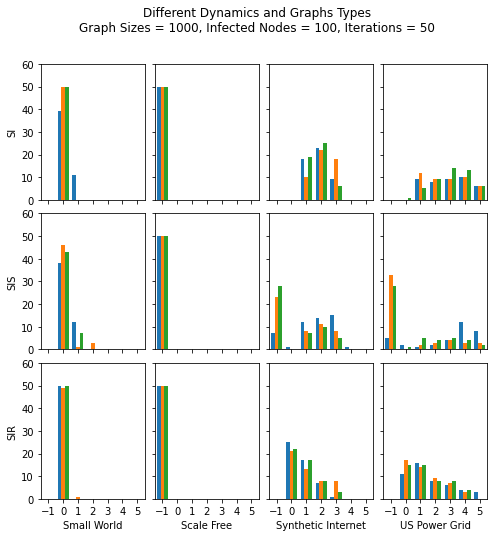

In [22]:
fig = matrix(len(simulations), len(graphs), len(predictors), data, sim_names, graph_names, (5, 60), (1, 10))
fig.suptitle(f"Different Dynamics and Graphs Types\nGraph Sizes = 1000, Infected Nodes = 100, Iterations = {times}")
plt.show()

## TODO:
- Connected Scale Free
- -1 -> Inf
- Why SIS x US Power Grid less -1: because rc works on unconnected
- Legend + same colors as Tim
- betweenness why not
- why synth internet better than us power